- Max Heading Difference between two consecutive waypoints
- Change in 1 second


# TO RUN
1. Make sure you installed all the dependencies
2. open **'init_notebook.py'** and change the **projectFolder** to the src folder of the repository.
3. In the following cell change the dataDir to the data directory of the InD dataset

In [2]:
dataDir = "/home/ababil/BUET/AV/location-2"
# dataDir = "D:/AV/Code/location-2"
# dataDir = "D:/AV/DataSetExploration/drone-dataset-tools/data/location-2"

In [3]:
exec(open('init_notebook.py').read())

current working dir/home/ababil/BUET/AV/Behavior Hypotheses/behavior-hypotheses/src


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tti_dataset_tools.TrajectoryTransformer import TrajectoryTransformer
from tti_dataset_tools.TrajectoryVisualizer import TrajectoryVisualizer
from tti_dataset_tools.TrajectoryCleaner import TrajectoryCleaner
from behavior_tools.TrajectoryADECalculator import TrajectoryADECalculator
from behavior_tools.Sampler import Sampler
from tti_dataset_tools.ColMapper import ColMapper

from behavior_tools.AngularDisplacementCalculator import AngularDisplacementCalculator

In [70]:
sceneId = 211
date = "2023-05-04"
fps=10
minYDisplacement = 5
maxXDisplacement = 6
pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
otherDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-others.csv"))
tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))

In [71]:
visualizer = TrajectoryVisualizer()
adeCalculator = TrajectoryADECalculator()
colMapper = ColMapper(
        idCol='uniqueTrackId', 
        xCol='sceneX', 
        yCol='sceneY',
        xVelCol='sceneXVelocity', 
        yVelCol='sceneYVelocity',
        xAccCol='sceneXAcceleration',
        yAccCol='sceneYAcceleration',
        speedCol='speed',
        accelerationCol='acceleration',
    )
transformer = TrajectoryTransformer(colMapper)
cleaner = TrajectoryCleaner(
    colMapper = colMapper,
    minSpeed = 0.0, # we can consider them as obstacles
    maxSpeed = 3.5,
    minAcceleration = 0.0,
    maxAcceleration = 2.0,   
    minYDisplacement = minYDisplacement,
    maxXDisplacement = maxXDisplacement
)
transformer.deriveSpeed(pedDf)
transformer.deriveDisplacements(pedDf)
transformer.deriveAcceleration(pedDf)
# plt.boxplot(pedDf['displacementY'])
# plt.show()
# plt.boxplot(pedDf['speed'])
# plt.show()
# plt.boxplot(pedDf['acceleration'])
# plt.show()

using min Y displacement (5)


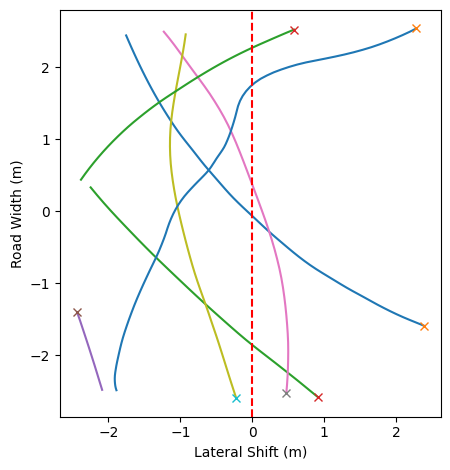

78

In [74]:
cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)

visualizer.show(pedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
# visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'sceneX', yCol = 'sceneY')
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
transformer.translateAllToLocalSource(cleanPedDf)

southIds = []
for pedId in allPedIds:
    trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
    # print(trackMeta['verticalDirection'])
    if trackMeta['verticalDirection'] == "SOUTH":
        southIds.append(pedId)
        # print(trackMeta["uniqueTrackId"])
        X, Y = transformer.rotate(trackDf)
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
        cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
len(cleanPedDf)


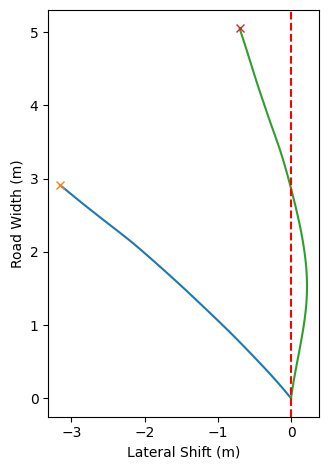

In [73]:
visualizer.show(cleanPedDf, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')

### Right side of the vertical axis (clockwise) is negative

In [9]:

startingDf = cleanPedDf[cleanPedDf["displacementY"] < 1].copy()
midDf = cleanPedDf[(cleanPedDf["displacementY"] >= 1) & (cleanPedDf["displacementY"] < 4)].copy()
endDf = cleanPedDf[(cleanPedDf["displacementY"] >= 4)].copy()
startingDf.head(10)

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [10]:
# plt.boxplot(startingDf["speed"])

In [11]:
# get the pedestrians who started at almost 0 speed.
# get pedestrians who started at almost the median speed.
medianStartingSpeed = startingDf["speed"].median()
medianStartingVelocityDf = startingDf[abs(startingDf["speed"] - medianStartingSpeed) < 0.005].copy()
medianStartingVelocityPedIds = list(medianStartingVelocityDf["uniqueTrackId"].unique())
# medianStartingVelocityPedIds

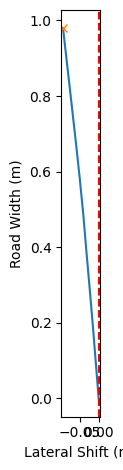

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489


In [12]:
starting023 = startingDf[startingDf["uniqueTrackId"] == 18023].copy()
visualizer.show(starting023, idCol = 'uniqueTrackId', xCol = 'localX', yCol = 'localY')
# starting023.size
starting023

In [13]:
angular023 = AngularDisplacementCalculator.addRelativeAngularDisplacement(starting023)
angular023

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement,absoluteAngularDisplacement
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0.000000,0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,0.000000,0.000000
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,-0.016269,0.016269
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0.099034,0.099034
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0.088696,0.088696
5,18,760,18023,210,5.0,0.670135,1.967831,-0.040911,0.486252,-0.011395,0.018314,0.487970,0.040735,0.487023,0.021570,-0.040735,0.487023,0.007028,0.007028
6,18,762,18023,210,5.0,0.679707,1.870670,-0.047861,0.485808,0.034750,0.002224,0.488159,0.050307,0.584184,0.034821,-0.050307,0.584184,0.140766,0.140766
7,18,764,18023,210,5.0,0.690215,1.773153,-0.052542,0.487584,0.023403,-0.008883,0.490407,0.060815,0.681701,0.025032,-0.060815,0.681701,0.176046,0.176046
8,18,766,18023,210,5.0,0.701232,1.674626,-0.055084,0.492634,0.012713,-0.025248,0.495704,0.071832,0.780228,0.028268,-0.071832,0.780228,0.162220,0.162220
9,18,768,18023,210,5.0,0.712428,1.575365,-0.055981,0.496305,0.004481,-0.018357,0.499452,0.083028,0.879489,0.018896,-0.083028,0.879489,0.132888,0.132888


In [14]:
angularStartingDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(startingDf)
angularStartingDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement,absoluteAngularDisplacement
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,0.000000,0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,0.000000,0.000000
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,-0.016269,0.016269
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,0.099034,0.099034
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,0.088696,0.088696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25855,29,28036,29534,210,5.0,-0.178826,2.119379,-0.166191,0.636080,-0.052322,0.019468,0.657432,0.808226,0.335475,0.055826,-0.068569,0.255211,-0.392486,0.392486
25856,29,28038,29534,210,5.0,-0.146855,1.991270,-0.159857,0.640545,-0.031668,-0.022326,0.660191,0.776255,0.463584,0.038747,-0.100541,0.383320,-0.341885,0.341885
25857,29,28040,29534,210,5.0,-0.115425,1.860413,-0.157150,0.654283,-0.013535,-0.068690,0.672892,0.744825,0.594440,0.070011,-0.131971,0.514177,-0.301959,0.301959
25858,29,28042,29534,210,5.0,-0.085571,1.726469,-0.149269,0.669719,-0.039406,-0.077177,0.686152,0.714971,0.728384,0.086655,-0.161825,0.648120,-0.375906,0.375906


In [15]:
# max absolute value of angular displacement
maxAngularDisplacement = angularStartingDf["relativeAngularDisplacement"].abs().max()
# get the rows with max angular displacement
maxAngularDisplacementDf = angularStartingDf[angularStartingDf["relativeAngularDisplacement"].abs() == maxAngularDisplacement].copy()
maxAngularDisplacementDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement,absoluteAngularDisplacement
19584,27,17135,27304,210,5.0,-0.007707,1.716572,-0.01607,0.575113,-0.190632,-0.155814,0.575337,0.637107,0.738281,0.246208,-0.204846,0.761989,-2.262937,2.262937


In [16]:
# get the whole track of the pedestrian with max angular displacement
maxAngularDisplacementPedId = maxAngularDisplacementDf.iloc[0]["uniqueTrackId"]
maxAngularDisplacementPedDf = angularStartingDf[angularStartingDf["uniqueTrackId"] == maxAngularDisplacementPedId].copy()
maxAngularDisplacementPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement,absoluteAngularDisplacement
19576,27,17119,27304,210,5.0,-0.212554,2.478561,-0.175700,0.401769,0.009550,-0.013824,0.438508,0.841954,0.023708,0.016802,-0.000000,-0.000000,0.000000,0.000000
19577,27,17121,27304,210,5.0,-0.176546,2.397488,-0.180040,0.405365,0.021698,-0.017978,0.443548,0.805946,0.057365,0.028178,-0.036008,0.081073,0.000000,0.000000
19578,27,17123,27304,210,5.0,-0.140301,2.315096,-0.181226,0.411963,0.005928,-0.032991,0.450062,0.769701,0.139758,0.033520,-0.072253,0.163466,-0.102248,0.102248
19579,27,17125,27304,210,5.0,-0.104334,2.229940,-0.179832,0.425780,-0.006970,-0.069083,0.462199,0.733734,0.224914,0.069434,-0.108219,0.248621,-0.323395,0.323395
19580,27,17127,27304,210,5.0,-0.071288,2.139879,-0.165234,0.450303,-0.072990,-0.122618,0.479662,0.700688,0.314975,0.142698,-0.141266,0.338682,-0.881147,0.881147
19581,27,17129,27304,210,5.0,-0.041859,2.043571,-0.147142,0.481541,-0.090460,-0.156190,0.503520,0.671259,0.411283,0.180495,-0.170694,0.434990,-1.215754,1.215754
19582,27,17131,27304,210,5.0,-0.021761,1.940385,-0.100494,0.515930,-0.233240,-0.171944,0.525626,0.651161,0.514469,0.289768,-0.190793,0.538176,-1.905196,1.905196
19583,27,17133,27304,210,5.0,-0.010921,1.831595,-0.054196,0.543950,-0.231487,-0.140098,0.546643,0.640321,0.623259,0.270580,-0.201632,0.646966,-2.210250,2.210250
19584,27,17135,27304,210,5.0,-0.007707,1.716572,-0.016070,0.575113,-0.190632,-0.155814,0.575337,0.637107,0.738281,0.246208,-0.204846,0.761989,-2.262937,2.262937
19585,27,17137,27304,210,5.0,-0.006437,1.598798,-0.006351,0.588873,-0.048596,-0.068801,0.588907,0.635837,0.856056,0.084233,-0.206117,0.879764,-1.861348,1.861348


In [17]:
def findMaxAngularDisplacementPedDf(df):
    angularDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(df)
    # get the max angular displacement
    maxAngularDisplacement = angularDf["absoluteAngularDisplacement"].max()
    # get the rows with max angular displacement
    maxAngularDisplacementDf = angularDf[angularDf["relativeAngularDisplacement"].abs() == maxAngularDisplacement].copy()
    return maxAngularDisplacementDf

findMaxAngularDisplacementPedDf(cleanPedDf)



,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,relativeAngularDisplacement,absoluteAngularDisplacement
19584,27,17135,27304,210,5.0,-0.007707,1.716572,-0.01607,0.575113,-0.190632,-0.155814,0.575337,0.637107,0.738281,0.246208,-0.204846,0.761989,-2.262937,2.262937


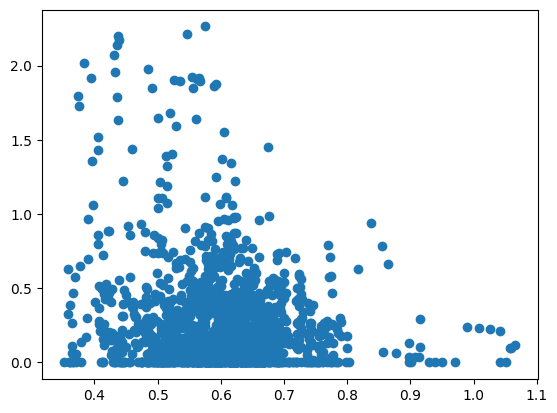

In [19]:
# plot a graph between absolute angular displacement and speed at each datapoint
plt.scatter(angularStartingDf["speed"], angularStartingDf["absoluteAngularDisplacement"])

In [21]:
# categorize speed 
# 0-0.5, 0.5-1, 1-10
cleanPedDf['speedCategory'] = pd.cut(cleanPedDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])

In [22]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,Low Speed
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,Low Speed
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,Low Speed
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,Low Speed
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,Low Speed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,Medium Speed
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,-0.006118,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,Medium Speed
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,-0.036321,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,Medium Speed
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,-0.017326,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,Medium Speed


In [23]:
cleanPedDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)

In [24]:
cleanPedDf

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,sceneYAcceleration,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,relativeAngularDisplacement,absoluteAngularDisplacement
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,-0.028943,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,Low Speed,0.000000,0.000000
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,0.003463,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,Low Speed,0.000000,0.000000
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,-0.028846,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,Low Speed,-0.016269,0.016269
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,-0.024797,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,Low Speed,0.099034,0.099034
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,0.008146,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,Low Speed,0.088696,0.088696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,0.042154,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,Medium Speed,0.111100,0.111100
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,-0.006118,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,Medium Speed,0.119128,0.119128
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,-0.036321,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,Medium Speed,0.127614,0.127614
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,-0.017326,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,Medium Speed,0.132349,0.132349


In [44]:
allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
len(allPedIds)
for pedId in allPedIds:
    pedDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
    # sum of absolute angular displacement each 10 rows of the df
    sumAngularDisplacementInASecond = pedDf["absoluteAngularDisplacement"].rolling(10).sum()
    # add the value as a new column
    cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'sumAngularDisplacementInASecond'] = sumAngularDisplacementInASecond
    
cleanPedDf
    

,recordingId,frame,uniqueTrackId,sceneId,roadWidth,sceneX,sceneY,sceneXVelocity,sceneYVelocity,sceneXAcceleration,...,speed,displacementX,displacementY,acceleration,localX,localY,speedCategory,relativeAngularDisplacement,absoluteAngularDisplacement,sumAngularDisplacementInASecond
0,18,750,18023,210,5.0,0.629400,2.454854,-0.047612,0.481508,-0.044860,...,0.483857,0.000000,0.000000,0.053387,-0.000000,-0.000000,Low Speed,0.000000,0.000000,NaN
1,18,752,18023,210,5.0,0.637141,2.358691,-0.038708,0.480816,-0.044520,...,0.482371,0.007742,0.096163,0.044655,-0.007742,0.096163,Low Speed,0.000000,0.000000,NaN
2,18,754,18023,210,5.0,0.644921,2.261374,-0.038896,0.486585,0.000940,...,0.488137,0.015521,0.193480,0.028862,-0.015521,0.193480,Low Speed,-0.016269,0.016269,NaN
3,18,756,18023,210,5.0,0.653314,2.163065,-0.041969,0.491544,0.015368,...,0.493333,0.023915,0.291789,0.029173,-0.023915,0.291789,Low Speed,0.099034,0.099034,NaN
4,18,758,18023,210,5.0,0.661952,2.065082,-0.043190,0.489915,0.006105,...,0.491815,0.032553,0.389772,0.010180,-0.032553,0.389772,Low Speed,0.088696,0.088696,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25886,29,28098,29534,210,5.0,0.774385,-2.095974,-0.193679,0.653773,0.023924,...,0.681858,0.144985,4.550828,0.048470,-1.021780,4.470564,Medium Speed,0.111100,0.111100,0.770067
25887,29,28100,29534,210,5.0,0.814397,-2.226974,-0.200064,0.654996,0.031928,...,0.684869,0.184998,4.681827,0.032509,-1.061793,4.601563,Medium Speed,0.119128,0.119128,0.833709
25888,29,28102,29534,210,5.0,0.856071,-2.359426,-0.208370,0.662260,0.041526,...,0.694267,0.226671,4.814279,0.055169,-1.103467,4.734015,Medium Speed,0.127614,0.127614,0.883582
25889,29,28104,29534,210,5.0,0.898967,-2.492571,-0.214476,0.665726,0.030534,...,0.699422,0.269567,4.947425,0.035107,-1.146362,4.867161,Medium Speed,0.132349,0.132349,0.942762


In [51]:
# max angular displacement in a second
maxAngularDisplacementInASecond = cleanPedDf["sumAngularDisplacementInASecond"].max()
print(maxAngularDisplacementInASecond)
# for each speed category, get the max angular displacement in a second
maxAngularDisplacementInASecondBySpeedCategory = cleanPedDf.groupby('speedCategory')['sumAngularDisplacementInASecond'].max()
maxAngularDisplacementInASecondBySpeedCategory

17.528857329687582


speedCategory
Low Speed       17.528857
Medium Speed    15.045314
High Speed       2.059256
Name: sumAngularDisplacementInASecond, dtype: float64

In [62]:
# ignore nan values
cleanPedDf_noNAN = cleanPedDf.dropna(subset=['sumAngularDisplacementInASecond'])
meanAngularDisplacementInASecondBySpeedCategory = cleanPedDf_noNAN.groupby('speedCategory')['sumAngularDisplacementInASecond'].mean()
meanAngularDisplacementInASecondBySpeedCategory

speedCategory
Low Speed       2.136728
Medium Speed    2.286401
High Speed      0.905357
Name: sumAngularDisplacementInASecond, dtype: float64

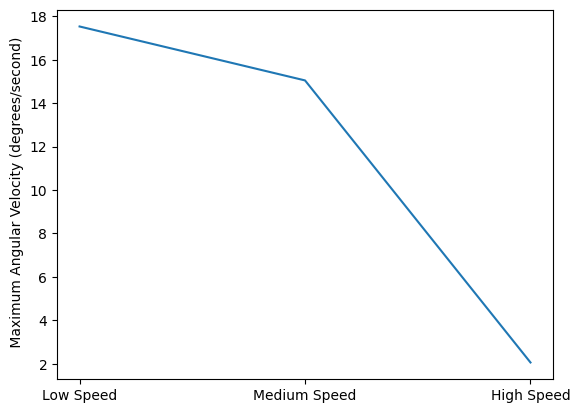

In [77]:
# plot the max and the mean angular displacement in a second by speed category
plt.plot(maxAngularDisplacementInASecondBySpeedCategory)
# plt.plot(meanAngularDisplacementInASecondBySpeedCategory, label="Mean Angular Velocity")
# plt.legend()
# plt.xlabel("Speed Category")
plt.ylabel(" Maximum Angular Velocity (degrees/second)")
plt.show()

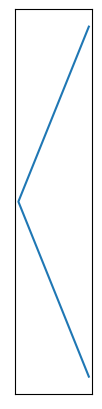

In [60]:
# plt.figure(figsize=(1, 5))
# draw to original scale
plt.figure(figsize=(1, 5))
t1 = [0, -.1, 0]
t2 = [0, 1, 2]
# no labels
plt.xticks([])
plt.yticks([])
plt.plot(t1, t2)

In [43]:
sumAngularDisplacementInASecond = angularStartingDf["absoluteAngularDisplacement"].rolling(10).sum()
sumAngularDisplacementInASecond

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
25855    1.327896
25856    1.274386
25857    1.419454
25858    1.681295
25859    2.062468
Name: absoluteAngularDisplacement, Length: 1511, dtype: float64

In [34]:
# find the max angular displacement for each speed category
def findMaxAngularDisplacement(df):
    # get the max angular displacement
    maxAngularDisplacement = df["relativeAngularDisplacement"].abs().max()
    return maxAngularDisplacement

maxAngularDisplacementDf = cleanPedDf.groupby('speedCategory').apply(findMaxAngularDisplacement)
maxAngularDisplacementDf

speedCategory
Low Speed       2.199288
Medium Speed    2.262937
High Speed      0.230092
dtype: float64

In [37]:
# find the max angular displacement for each speed category in each scene
def getMaxAngularDisplacementScenewise(sceneId, date, fps, dataDir, minYDisplacement, maxXDisplacement):
    pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
    tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))
    transformer = TrajectoryTransformer(colMapper)
    cleaner = TrajectoryCleaner(
        colMapper = colMapper,
        minSpeed = 0.0, # we can consider them as obstacles
        maxSpeed = 3.5,
        minAcceleration = 0.0,
        maxAcceleration = 2.0,   
        minYDisplacement = minYDisplacement,
        maxXDisplacement = maxXDisplacement
    )
    transformer.deriveSpeed(pedDf)
    transformer.deriveDisplacements(pedDf)
    transformer.deriveAcceleration(pedDf)
    cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
    
    allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
    transformer.translateAllToLocalSource(cleanPedDf)

    southIds = []
    for pedId in allPedIds:
        trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
        trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
        # print(trackMeta['verticalDirection'])
        if trackMeta['verticalDirection'] == "SOUTH":
            southIds.append(pedId)
            # print(trackMeta["uniqueTrackId"])
            X, Y = transformer.rotate(trackDf)
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
    # len(cleanPedDf)

    angularDisplacementDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)
    angularDisplacementDf['speedCategory'] = pd.cut(angularDisplacementDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])
    maxAngularDisplacementDf = angularDisplacementDf.groupby('speedCategory').apply(findMaxAngularDisplacement)
    return maxAngularDisplacementDf

scenes = [210, 211, 220, 221, 230, 231, 240, 222]
scenesMaxAngularDisplacement = []
for sceneId in scenes:
    scenesMaxAngularDisplacement.append(getMaxAngularDisplacementScenewise(sceneId, "2023-05-04", 10, dataDir, 5, 6))

using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)
using min Y displacement (5)


ValueError: No objects to concatenate

In [40]:
scenesMaxAngularDisplacementDf = pd.concat(scenesMaxAngularDisplacement, axis=1)
scenesMaxAngularDisplacementDf.columns = scenes[:5]
scenesMaxAngularDisplacementDf

,210,211,220,221,230
speedCategory,,,,,
Low Speed,2.199288,NaN,356.740408,5.266171,17.111889
Medium Speed,2.262937,0.784789,2.699655,2.491750,29.699685
High Speed,0.230092,NaN,0.977728,NaN,NaN


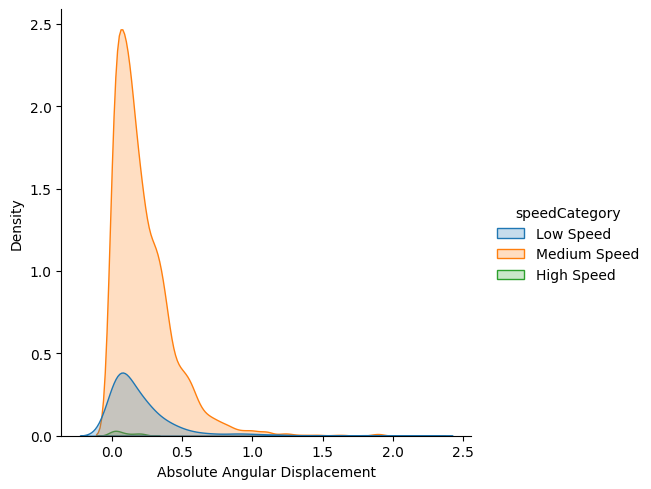

In [29]:
# plot distribution of angular displacement for each speed category
sns.displot(cleanPedDf, x="absoluteAngularDisplacement", hue="speedCategory", kind="kde", fill=True)
plt.xlabel("Absolute Angular Displacement")
plt.ylabel("Density")

plt.show()


using min Y displacement (5)


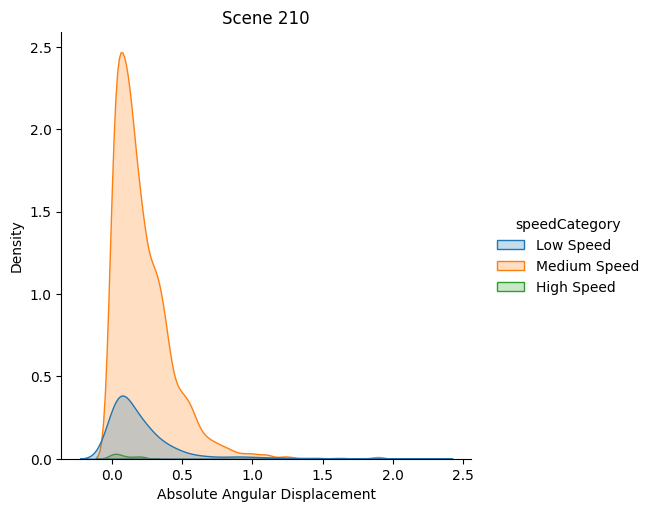

In [32]:
# write a function for getting the above plot for given sceneId
def getAngularDisplacementDistribution(sceneId, date, fps, dataDir, minYDisplacement, maxXDisplacement):
    pedDf = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-pedestrians.csv"))
    tracksMeta = pd.read_csv(os.path.join(dataDir, f"{date}-fps-{fps}-scene-{sceneId}-meta.csv"))
    transformer = TrajectoryTransformer(colMapper)
    cleaner = TrajectoryCleaner(
        colMapper = colMapper,
        minSpeed = 0.0, # we can consider them as obstacles
        maxSpeed = 3.5,
        minAcceleration = 0.0,
        maxAcceleration = 2.0,   
        minYDisplacement = minYDisplacement,
        maxXDisplacement = maxXDisplacement
    )
    transformer.deriveSpeed(pedDf)
    transformer.deriveDisplacements(pedDf)
    transformer.deriveAcceleration(pedDf)
    cleanPedDf = cleaner.cleanByYDisplacement(pedDf, byIQR=False)
    
    allPedIds = list(cleanPedDf["uniqueTrackId"].unique())
    transformer.translateAllToLocalSource(cleanPedDf)

    southIds = []
    for pedId in allPedIds:
        trackDf = cleanPedDf[cleanPedDf["uniqueTrackId"] == pedId]
        trackMeta = tracksMeta[tracksMeta["uniqueTrackId"] == pedId].iloc[0]
        # print(trackMeta['verticalDirection'])
        if trackMeta['verticalDirection'] == "SOUTH":
            southIds.append(pedId)
            # print(trackMeta["uniqueTrackId"])
            X, Y = transformer.rotate(trackDf)
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localX'] = X
            cleanPedDf.loc[cleanPedDf["uniqueTrackId"] == pedId, 'localY'] = Y
    # len(cleanPedDf)

    angularDisplacementDf = AngularDisplacementCalculator.addRelativeAngularDisplacement(cleanPedDf)
    angularDisplacementDf['speedCategory'] = pd.cut(angularDisplacementDf['speed'], bins=[0, 0.5, 1.0, 10], labels=['Low Speed', 'Medium Speed', 'High Speed'])
    sns.displot(angularDisplacementDf, x="absoluteAngularDisplacement", hue="speedCategory", kind="kde", fill=True)
    plt.xlabel("Absolute Angular Displacement")
    plt.ylabel("Density")
    plt.title(f"Scene {sceneId}")
    plt.show()
    
getAngularDisplacementDistribution(210, "2023-05-04", 10, dataDir, 5, 6)

using min Y displacement (5)


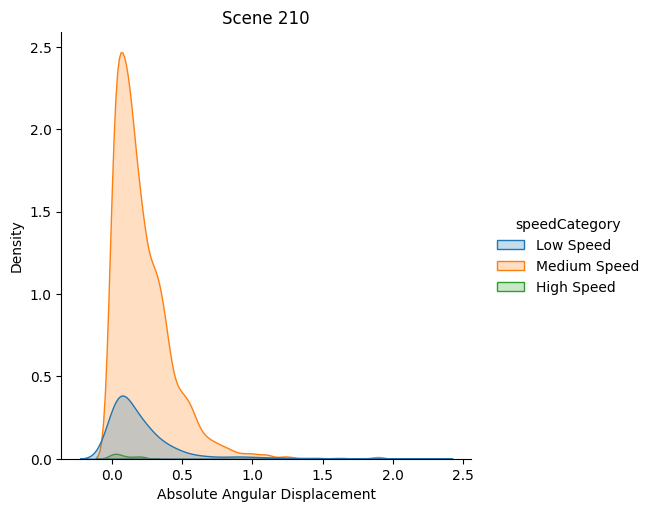

using min Y displacement (5)


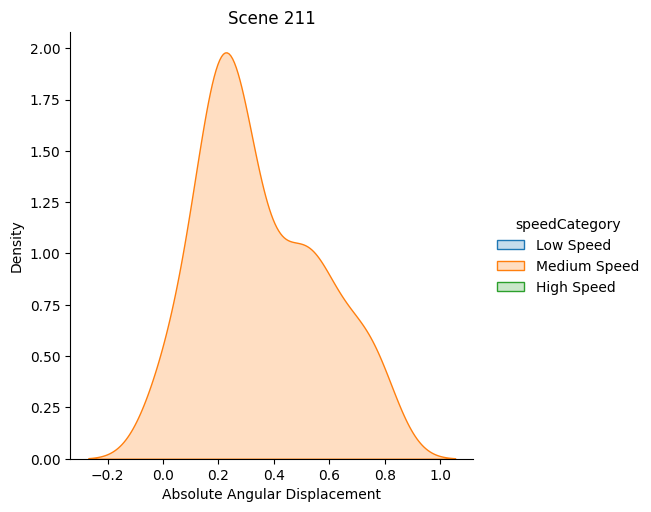

using min Y displacement (5)


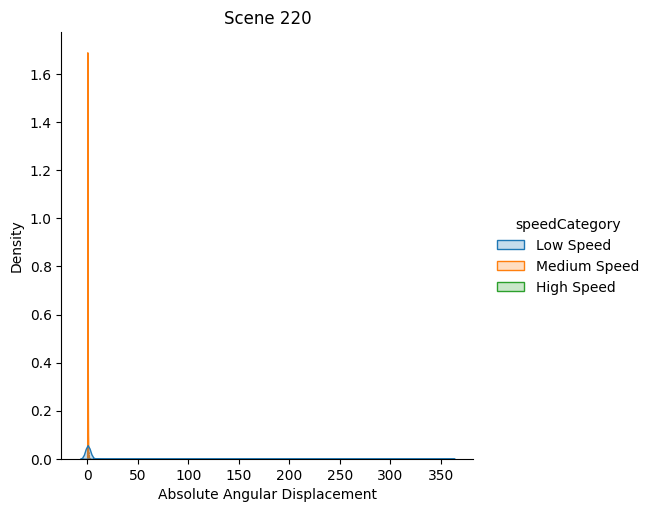

using min Y displacement (5)


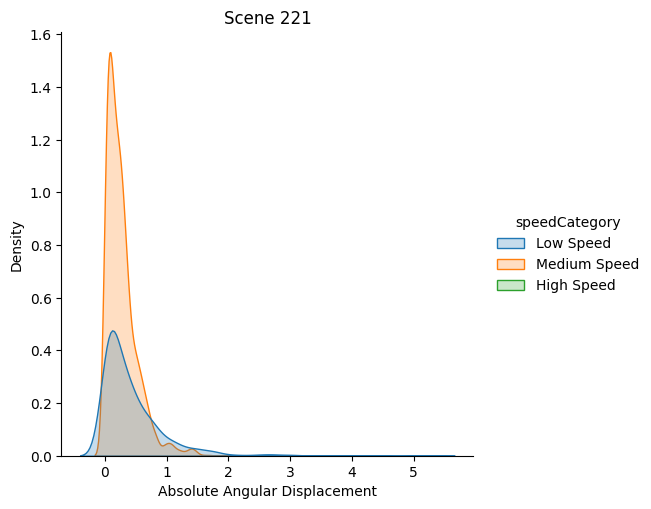

using min Y displacement (5)


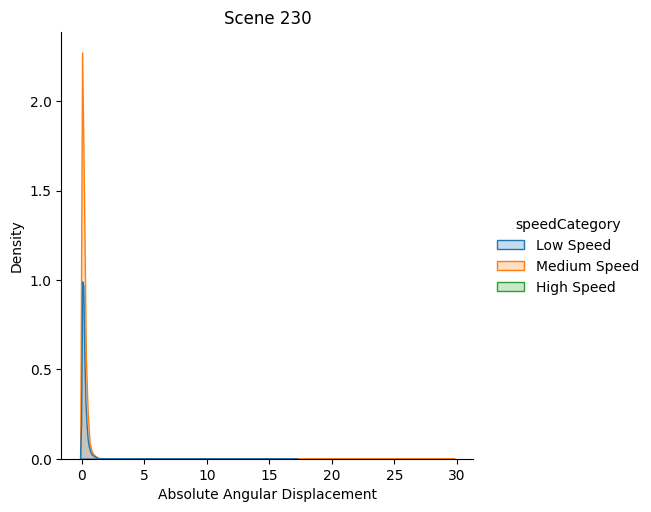

using min Y displacement (5)


ValueError: No objects to concatenate

In [33]:
# plot for all scenes from scenes array
scenes = [210, 211, 220, 221, 230, 231, 240, 222]
for sceneId in scenes:
    getAngularDisplacementDistribution(sceneId, "2023-05-04", 10, dataDir, 5, 6)

In [19]:
NO_OF_CATEGORY = 3

def assign_category(value_column, num_categories):
    min_value = value_column.min()
    max_value = value_column.max()
    value_range = max_value - min_value
    category_range = value_range / num_categories
    
    def categorize(speed):
        category = int((speed - min_value) / category_range)
        return min(category, num_categories - 1)
    
    categories = value_column.apply(categorize)
    return categories

In [20]:
def maxAngDisVsSpeed(dataframe):
    
    total_length = len(dataframe)
    maxAngularDisplacementDf = findMaxAngularDisplacementPedDf(dataframe)
    col1 = 'maxAngularDisplacement'
    col2 = 'Speed'

    maxAngularDisplacementDf['category1'] = assign_category(maxAngularDisplacementDf[col1], NO_OF_CATEGORY)
    maxAngularDisplacementDf['category2'] = assign_category(maxAngularDisplacementDf[col2], NO_OF_CATEGORY)

    heatmapDf = pd.DataFrame(columns = [col1, col2, 'count'])
    heatmapDf['maxAngularDisplacement'] = maxAngularDisplacementDf['category1']
    heatmapDf['Speed'] = maxAngularDisplacementDf['category2']
    heatmapDf['count'] = 1
    heatmapDf = heatmapDf.groupby(['maxAngularDisplacement', 'Speed']).count().reset_index()
    
    heatmapDf = heatmapDf.pivot(index='maxAngularDisplacement', columns='Speed', values='count')

    # heatmapDf_swap = find_RankA(heatmapDf)
    df = heatmapDf.iloc[::-1]
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df/total_length, annot=True, fmt=".6f", cmap='YlGnBu')
    
    x_labels = ["low", "medium", "high"]
    y_labels = ["high", "medium", "low"]
    
    count = 3
    
    plt.xticks(np.arange(0.5, count+0.5, 1), x_labels)
    plt.yticks(np.arange(0.5, count+0.5, 1), y_labels)

    plt.xlabel("Speed")
    plt.ylabel("maxAngularDisplacement")

    plt.show()


In [21]:
maxAngDisVsSpeed(cleanPedDf)

KeyError: 'maxAngularDisplacement'